# 2.5D Convolutional Network for Brain Tumor Segmentation

In [70]:
# neural imaging
import nibabel as nib

import os
import numpy as np
import matplotlib.pyplot as plt

import kagglehub

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm


## Download the brats dataset

In [71]:
# Download latest version
path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")

print("Path to dataset files:", path)

Path to dataset files: /Users/arnewiese/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1


In [72]:
TRAIN_DATASET_PATH = path + '/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

## Create the dataset class

In [73]:
class BraTSDataset(Dataset):
    """
    Custom PyTorch Dataset for BraTS 2020 brain tumor segmentation.

    Loads 3D MRI volumes and extracts 2.5D slices for training by aggregating
    multiple consecutive slices.
    """

    def __init__(self, patient_list, data_dir, slice_range=(2, 153), n_slices=5):
        """
        Args:
            patient_list: List of patient folder names (e.g., ['BraTS20_Training_001', ...])
            data_dir: Path to the data directory
            slice_range: Tuple (min_slice, max_slice) to focus on brain region with tumors
            n_slices: Number of consecutive slices to aggregate (must be odd for symmetry)
        """
        self.data_dir = data_dir
        self.slice_range = slice_range
        self.n_slices = n_slices
        self.half_slices = n_slices // 2
        self.samples = []  # Will store (patient_id, slice_index) pairs

        # For each patient, identify which slices contain tumor
        for patient_id in patient_list:
            # Only include slices within our range that have enough context slices
            for slice_idx in range(slice_range[0], slice_range[1]):
                self.samples.append((patient_id, slice_idx))

    def __len__(self):
        """Return total number of samples (2D slices)"""
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Load and return one sample (a single 2D slice with aggregated context from n slices).

        Returns:
            image: Tensor of shape (4, 240, 240) - 4 MRI modalities with aggregated slices
            mask: Tensor of shape (240, 240) - segmentation labels (center slice)
        """
        patient_id, slice_idx = self.samples[idx]
        patient_path = os.path.join(self.data_dir, patient_id)

        # Load all 4 modalities for this slice and neighboring slices
        modalities = ['flair', 't1', 't1ce', 't2']
        aggregated_slices = []

        for modality in modalities:
            file_path = os.path.join(patient_path, f"{patient_id}_{modality}.nii")
            volume = nib.load(file_path).get_fdata()
            
            # Collect n_slices around the center slice
            slices_to_aggregate = []
            for offset in range(-self.half_slices, self.half_slices + 1):
                idx_to_load = slice_idx + offset
                slice_2d = volume[:, :, idx_to_load]
                slice_2d = self.normalize(slice_2d)
                slices_to_aggregate.append(slice_2d)
            
            # Aggregate by taking the mean across slices
            aggregated_slice = np.mean(slices_to_aggregate, axis=0)
            aggregated_slices.append(aggregated_slice)

        # Stack into (4, 240, 240) tensor
        image = np.stack(aggregated_slices, axis=0)

        # Load segmentation mask (only the center slice)
        seg_path = os.path.join(patient_path, f"{patient_id}_seg.nii")
        seg_volume = nib.load(seg_path).get_fdata()
        mask = seg_volume[:, :, slice_idx]

        # Convert labels: 0->0, 1->1, 2->2, 4->3 (to have consecutive labels)
        mask[mask == 4] = 3

        # Convert to PyTorch tensors
        image = torch.FloatTensor(image)
        mask = torch.LongTensor(mask.astype(np.int64))

        return image, mask

    def normalize(self, slice_2d):
        """Normalize a 2D slice to [0, 1] range"""
        min_val = slice_2d.min()
        max_val = slice_2d.max()

        if max_val - min_val > 0:
            return (slice_2d - min_val) / (max_val - min_val)
        else:
            return slice_2d


## Create Train/Val/Test split

In [74]:
all_patients = sorted([d for d in os.listdir(TRAIN_DATASET_PATH)
                      if os.path.isdir(os.path.join(TRAIN_DATASET_PATH, d))])

# First split: 70% train, 30% temp
train_patients, temp_patients = train_test_split(
    all_patients, test_size=0.30, random_state=42
)

# Second split: split temp into 50/50 (15% val, 15% test of original)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.50, random_state=42
)

print(f"Train: {len(train_patients)} patients")
print(f"Val: {len(val_patients)} patients")
print(f"Test: {len(test_patients)} patients")


# Create datasets from preprocessed arrays
train_dataset = BraTSDataset(train_patients[:2],TRAIN_DATASET_PATH)
val_dataset = BraTSDataset(val_patients[:2], TRAIN_DATASET_PATH)
test_dataset = BraTSDataset(test_patients[:2], TRAIN_DATASET_PATH)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

Train: 258 patients
Val: 55 patients
Test: 56 patients


In [75]:
## Build the U-Net Model

In [76]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    """
    Basic U-Net architecture for brain tumor segmentation.
    
    Input: (batch_size, 4, 240, 240) - 4 MRI modalities
    Output: (batch_size, 4, 240, 240) - 4 segmentation classes
    """
    
    def __init__(self, n_channels=4, n_classes=4):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        
        return logits


## Initialize Model, Loss and Optimizer

In [77]:
# Set device - prioritize MPS for Mac, then CUDA, then CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f"Using device: {device}")

# Initialize model
model = UNet(n_channels=4, n_classes=4).to(device)

# Loss function - CrossEntropyLoss for multi-class segmentation
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")


Using device: mps
Model has 31044292 parameters
Model has 31044292 parameters


## Dice Score Metric

In [78]:
def dice_score(pred, target, num_classes=4):
    """
    Calculate Dice score for multi-class segmentation.
    
    Args:
        pred: Predicted logits (B, C, H, W)
        target: Ground truth labels (B, H, W)
        num_classes: Number of segmentation classes
    
    Returns:
        Mean Dice score across all classes
    """
    pred = torch.argmax(pred, dim=1)  # (B, H, W)
    dice_scores = []
    
    for class_id in range(num_classes):
        pred_class = (pred == class_id).float()
        target_class = (target == class_id).float()
        
        intersection = (pred_class * target_class).sum()
        union = pred_class.sum() + target_class.sum()
        
        if union == 0:
            dice_scores.append(1.0)  # Perfect score if both are empty
        else:
            dice = (2.0 * intersection) / union
            dice_scores.append(dice.item())  # Convert to Python float

    return np.mean(dice_scores)


## Training and Validation Functions

In [79]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    
    pbar = tqdm(dataloader, desc="Training", leave=False)
    for batch_idx, (images, masks) in enumerate(pbar):
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Metrics
        running_loss += loss.item()
        running_dice += dice_score(outputs, masks)
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_dice = running_dice / len(dataloader)
    
    return epoch_loss, epoch_dice


def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation", leave=False)
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Metrics
            running_loss += loss.item()
            running_dice += dice_score(outputs, masks)
            
            # Update progress bar
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_dice = running_dice / len(dataloader)
    
    return epoch_loss, epoch_dice


## Training Loop

In [80]:
num_epochs = 3
best_val_dice = 0.0

# Lists to store metrics for plotting
train_losses = []
train_dices = []
val_losses = []
val_dices = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Training
    train_loss, train_dice = train_one_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
    
    # Validation
    val_loss, val_dice = validate(model, val_loader, criterion, device)
    print(f"Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")
    
    # Store metrics
    train_losses.append(train_loss)
    train_dices.append(train_dice)
    val_losses.append(val_loss)
    val_dices.append(val_dice)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': val_dice,
        }, 'best_model.pth')
        print(f"✓ Saved new best model with Dice: {val_dice:.4f}")

print("\nTraining completed!")
print(f"Best validation Dice score: {best_val_dice:.4f}")



Epoch 1/3
--------------------------------------------------


Train Loss: 1.3930, Train Dice: 0.1844


Val Loss: 1.2640, Val Dice: 0.2685
✓ Saved new best model with Dice: 0.2685

Epoch 2/3
--------------------------------------------------
✓ Saved new best model with Dice: 0.2685

Epoch 2/3
--------------------------------------------------


Train Loss: 1.0315, Train Dice: 0.3872


Val Loss: 1.0055, Val Dice: 0.3394
✓ Saved new best model with Dice: 0.3394

Epoch 3/3
--------------------------------------------------
✓ Saved new best model with Dice: 0.3394

Epoch 3/3
--------------------------------------------------


Train Loss: 0.9363, Train Dice: 0.4470


Val Loss: 1.4185, Val Dice: 0.4773
✓ Saved new best model with Dice: 0.4773

Training completed!
Best validation Dice score: 0.4773
✓ Saved new best model with Dice: 0.4773

Training completed!
Best validation Dice score: 0.4773


## Plot Training History

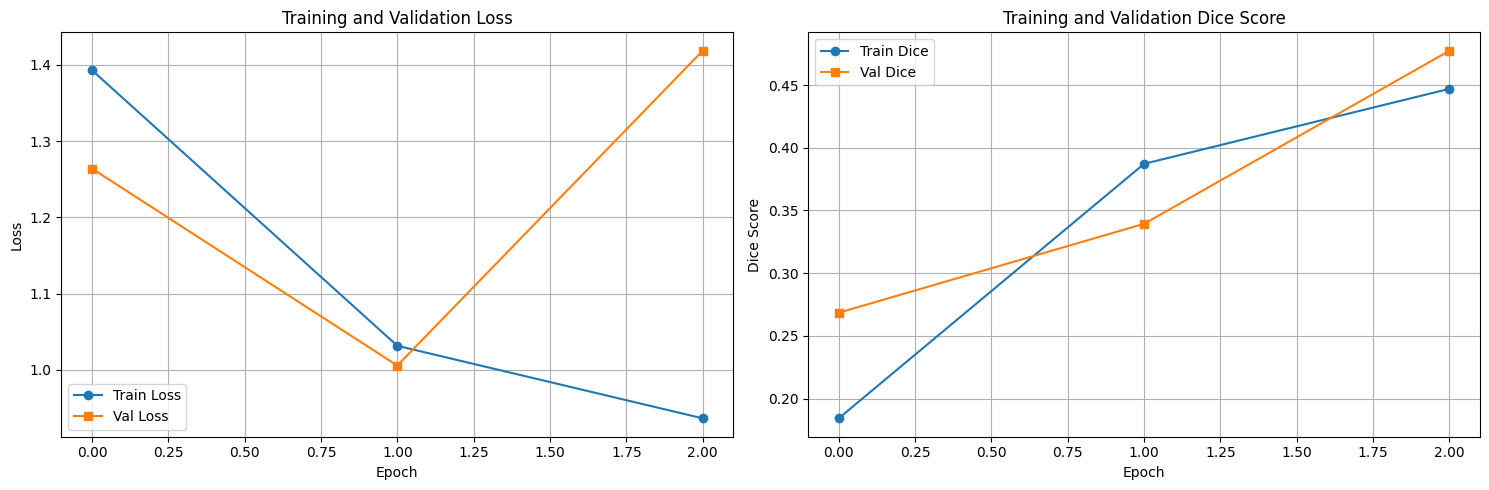

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot Dice score
axes[1].plot(train_dices, label='Train Dice', marker='o')
axes[1].plot(val_dices, label='Val Dice', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Training and Validation Dice Score')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Visualize Predictions

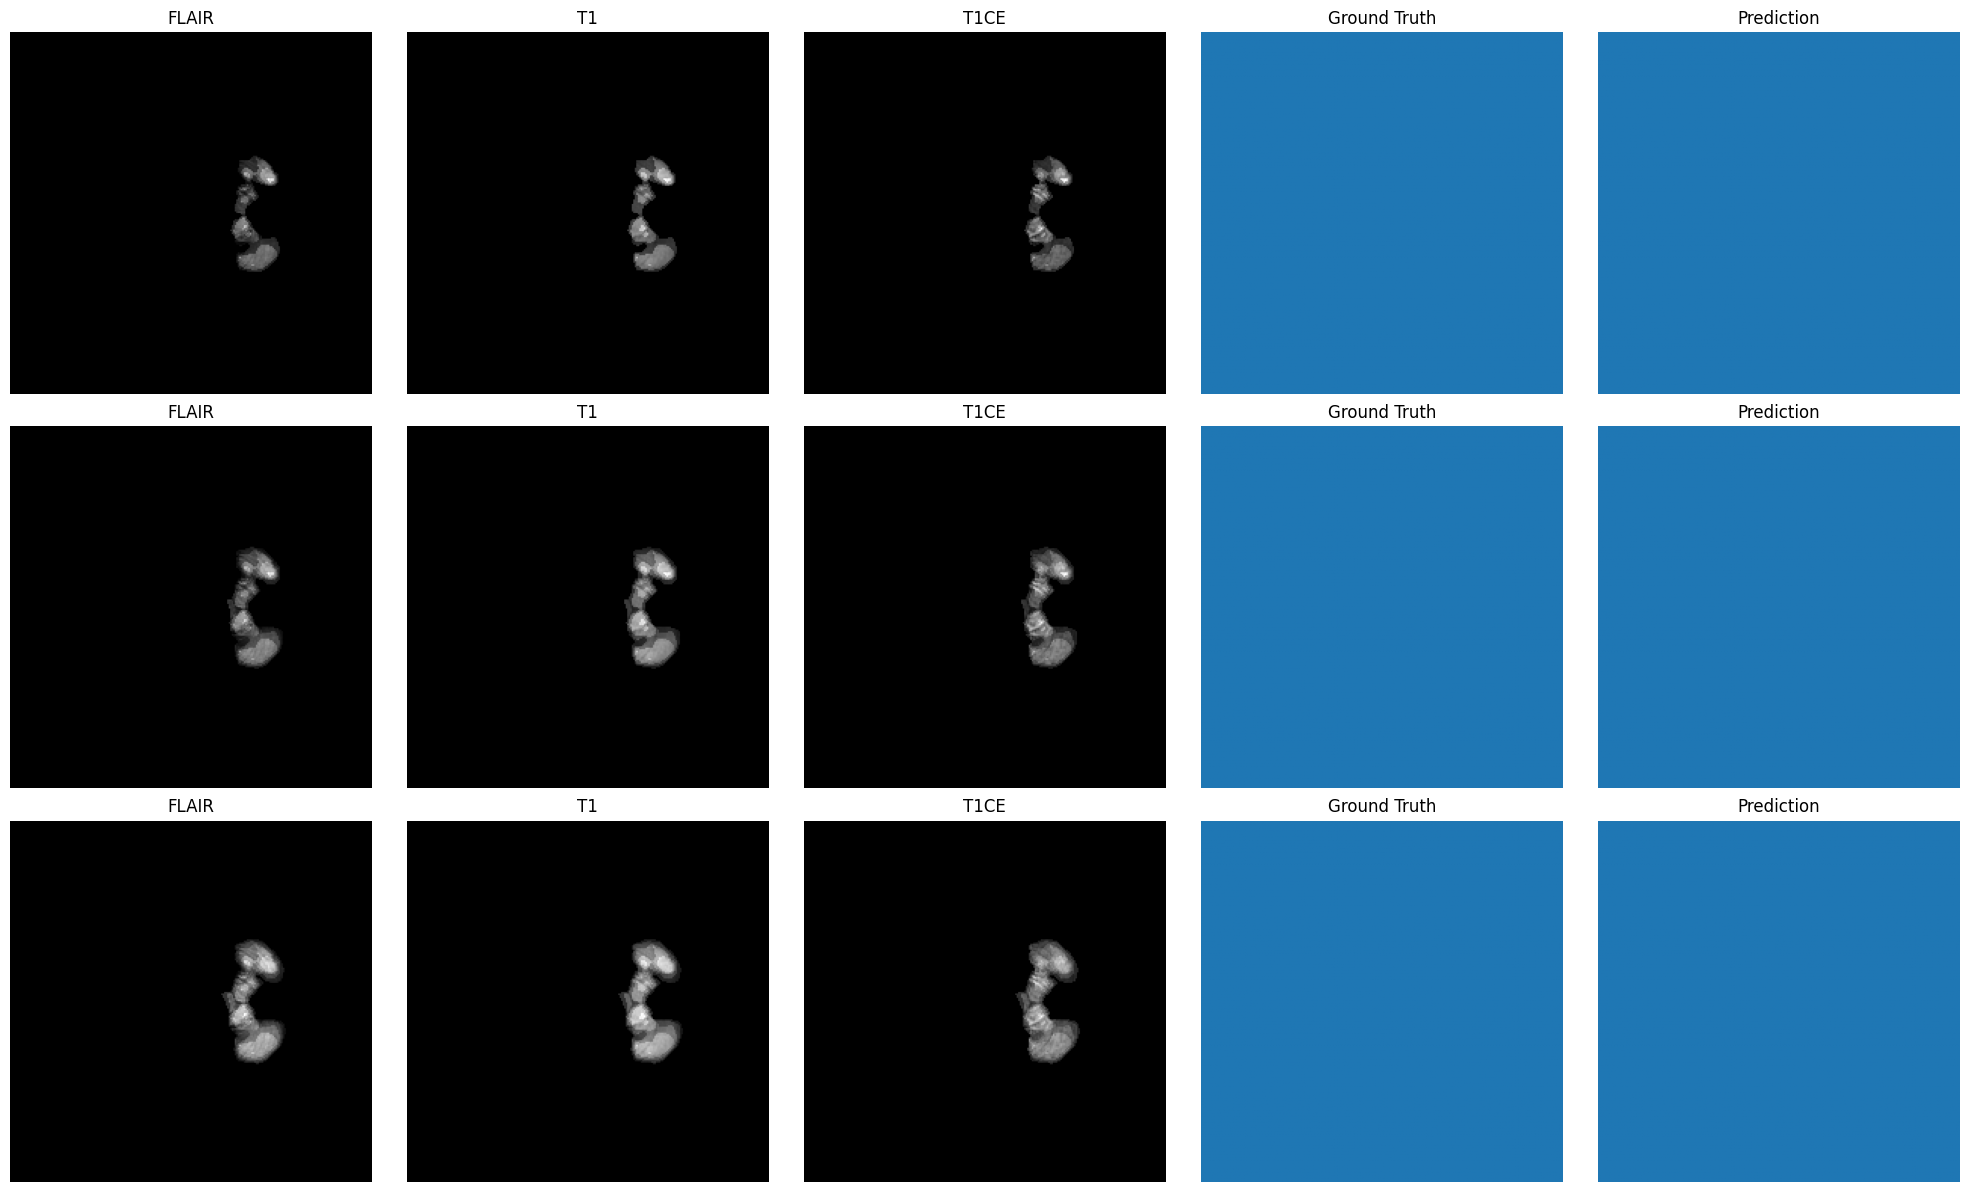

In [82]:
def visualize_predictions(model, dataloader, device, num_samples=3):
    """Visualize some predictions from the model"""
    model.eval()
    
    # Get a batch
    images, masks = next(iter(dataloader))
    images = images.to(device)
    masks = masks.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)
    
    # Move to CPU for visualization
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    predictions = predictions.cpu().numpy()
    
    # Plot
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    
    for i in range(num_samples):
        # Show FLAIR modality
        axes[i, 0].imshow(images[i, 0], cmap='gray')
        axes[i, 0].set_title('FLAIR')
        axes[i, 0].axis('off')
        
        # Show T1 modality
        axes[i, 1].imshow(images[i, 1], cmap='gray')
        axes[i, 1].set_title('T1')
        axes[i, 1].axis('off')
        
        # Show T1CE modality
        axes[i, 2].imshow(images[i, 2], cmap='gray')
        axes[i, 2].set_title('T1CE')
        axes[i, 2].axis('off')
        
        # Show ground truth mask
        axes[i, 3].imshow(masks[i], cmap='tab10', vmin=0, vmax=3)
        axes[i, 3].set_title('Ground Truth')
        axes[i, 3].axis('off')
        
        # Show prediction
        axes[i, 4].imshow(predictions[i], cmap='tab10', vmin=0, vmax=3)
        axes[i, 4].set_title('Prediction')
        axes[i, 4].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some validation samples
visualize_predictions(model, val_loader, device, num_samples=3)


## Evaluate on Test Set

Loaded best model from epoch 2 with val Dice: 0.4773



Test Loss: 5.2741
Test Dice Score: 0.3458


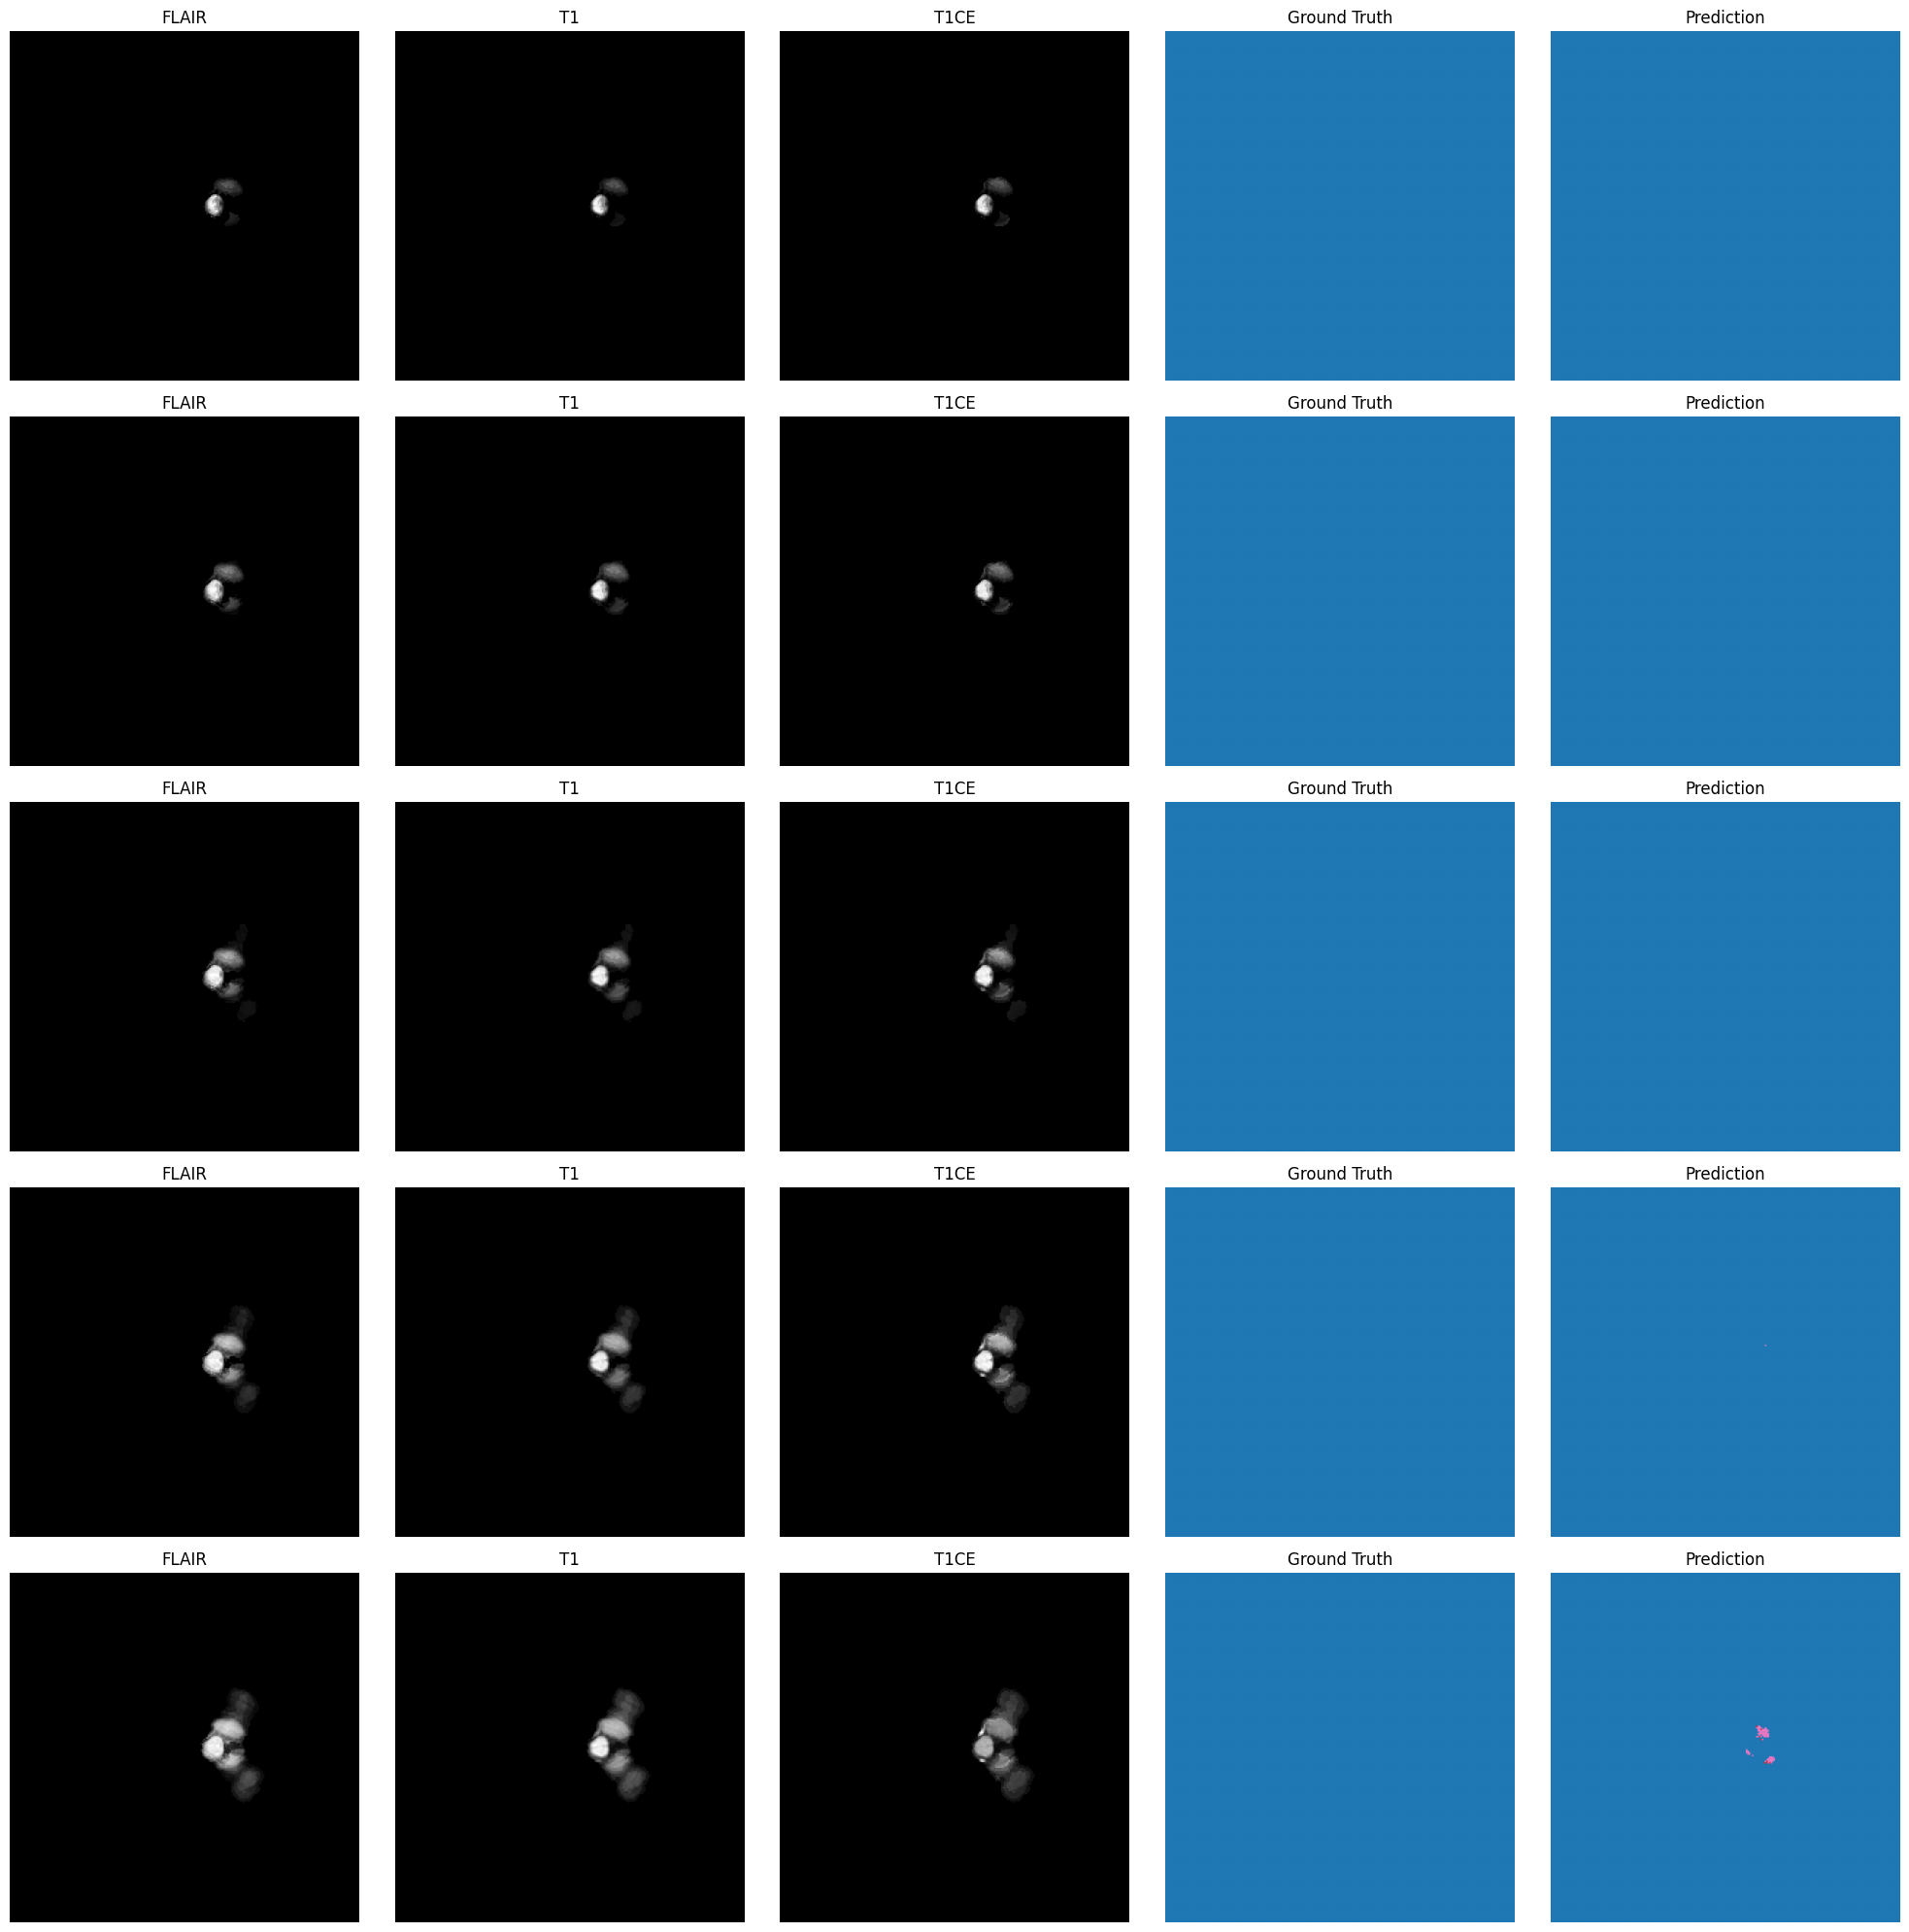

In [83]:
# Load best model
checkpoint = torch.load('best_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']} with val Dice: {checkpoint['val_dice']:.4f}")

# Evaluate on test set
test_loss, test_dice = validate(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Dice Score: {test_dice:.4f}")

# Visualize test predictions
visualize_predictions(model, test_loader, device, num_samples=5)
